In [1]:
import json

from matplotlib_venn_wordcloud import venn2_wordcloud, venn3_wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import folium
from folium import plugins

%matplotlib inline

За основу для источников данных используется модифицированный код сбора вакансий с hh.ru за последние 30 дней, с возможностью сохранять промежуточные данные со строкой, используемой при поиске.
Данные получены путем поиска по следующим строкам (названиям должностей в области data analysis):  
- Data Analyst
- Data Scientist
- Data Engineer
- Machine Learning Engineer

**vacancies.json** - файл с основной информацией по вакансиям, со строкой, используемой при поиске (как следствие, одна вакансия может дублировать для различных поисковых строк)  
**vacancies_detail.json** - файл с детальной информацией по уникальным вакансиям из vacancies.json  
**quotes.json** - файл с курсами валют к российскому рублю

In [2]:
df = pd.read_json('./data/vacancies.json', orient='records')
df.shape

(2689, 55)

In [3]:
selected_columns = ['id', 'created_at',
                    'snippet.requirement', 'snippet.responsibility', 'search_text']
df = df[selected_columns]
df.head()

,id,created_at,snippet.requirement,snippet.responsibility,search_text
0,25069525,2018-04-14 13:40:33,...данных и машинному обучению (Kaggle и др.)....,"Постановка задач анализа данных, участие в нап...",Data Analyst
1,25163746,2018-04-14 08:47:19,"Высшее образование (математика, статистика, ин...","Сбор, валидация, анализ и интерпретация данных...",Data Analyst
2,25393603,2018-04-14 14:18:05,Знание SQL. Опыт работы в роли <highlighttext>...,"Анализ текущих показателей продукта, определен...",Data Analyst
3,24126135,2018-04-14 13:26:41,"статистическими пакетами (SPSS, STATISTICA и т...",Участие в разработке аналитических продуктов д...,Data Analyst
4,23305323,2018-04-14 07:43:02,"Мы ищем сложившегося профессионала, человека с...","Вы будете отвечать за исследования данных, про...",Data Analyst


In [4]:
detail_df = pd.read_json('./data/vacancies_detail.json', orient='records')
detail_df.shape

(2166, 80)

In [5]:
selected_detail_columns = ['id', 'name', 'area.name', 'key_skills', 'specializations',
                           'salary.from', 'salary.to', 'salary.currency', 'salary.gross',
                           'schedule.name', 'experience.name', 'employer.name',
                           'address.city', 'address.lat', 'address.lng']
detail_df = detail_df[selected_detail_columns]
detail_df.head()

,id,name,area.name,key_skills,specializations,salary.from,salary.to,salary.currency,salary.gross,schedule.name,experience.name,employer.name,address.city,address.lat,address.lng
0,25069525,Senior Data Scientist,Москва,[],"[{'profarea_id': '1', 'profarea_name': 'Информ...",NaN,NaN,None,NaN,Полный день,От 3 до 6 лет,ДАТАДВАНС,Москва,55.654137,37.555876
1,25163746,Data Scientist,Минск,"[{'name': 'Data Analysis'}, {'name': 'Data Min...","[{'profarea_id': '1', 'profarea_name': 'Информ...",NaN,NaN,None,NaN,Полный день,От 1 года до 3 лет,БД Технологии,Минск,53.909583,27.596829
2,25393603,Data analyst / Аналитик данных,Минск,[],"[{'profarea_id': '1', 'profarea_name': 'Информ...",NaN,NaN,None,NaN,Полный день,От 1 года до 3 лет,Koovalda studios / ООО КамориГруп,Минск,53.924702,27.511606
3,24126135,Специалист по углубленной аналитике данных (da...,Минск,"[{'name': 'SPSS'}, {'name': 'Статистический ан...","[{'profarea_id': '3', 'profarea_name': 'Маркет...",NaN,NaN,None,NaN,Полный день,От 1 года до 3 лет,velcom (Унитарное предприятие «Велком»),None,NaN,NaN
4,23305323,Data Scientist,Москва,"[{'name': 'Data Science'}, {'name': 'Python'},...","[{'profarea_id': '14', 'profarea_name': 'Наука...",NaN,NaN,None,NaN,Полный день,От 1 года до 3 лет,МТС,None,NaN,NaN


In [6]:
# Объединим детальную информацию по вакансиям с доп. информацией (включая поисковую строку), и сохрани
all_vacancies_df = pd.merge(df, detail_df, on='id')
all_vacancies_df.to_json('./data/all_vacancies.json', orient='records')
all_vacancies_df.shape

(2689, 19)

In [7]:
quotes_df = pd.read_json('./data/quotes.json', orient='index')
quotes_df.head()

,currency.rate
AED,16.888308
AFN,0.889799
ALL,0.595192
AMD,0.128558
ANG,34.834249


In [8]:
sns.set(style='white')
plt.rc('figure', figsize = (14, 8))
plt.rc('font', size=12)

### Какие общие и уникальные для указанных должностей навыки нужны?

In [9]:
# Получим данные по ключевым навыкам, в разрезе должностей, которые использовались при поиске
with open('./data/all_vacancies.json') as f:
    json_data = f.read()

key_skills_df = pd.io.json.json_normalize(json.loads(json_data), record_path='key_skills', 
                                          meta=['id','search_text'])
key_skills_df['name'] = key_skills_df['name'].str.lower()
key_skills_df.head()

,name,id,search_text
0,data analysis,25163746,Data Analyst
1,data mining,25163746,Data Analyst
2,spss,25163746,Data Analyst
3,data analysis,25163746,Data Scientist
4,data mining,25163746,Data Scientist


Найдем top 15 наиболее важных ключевых навыков для каждой из должности, объединим все навыки в единое множество, и отобразим пропорции вакансий, которые включают данные ключевые навыки для различных должностей

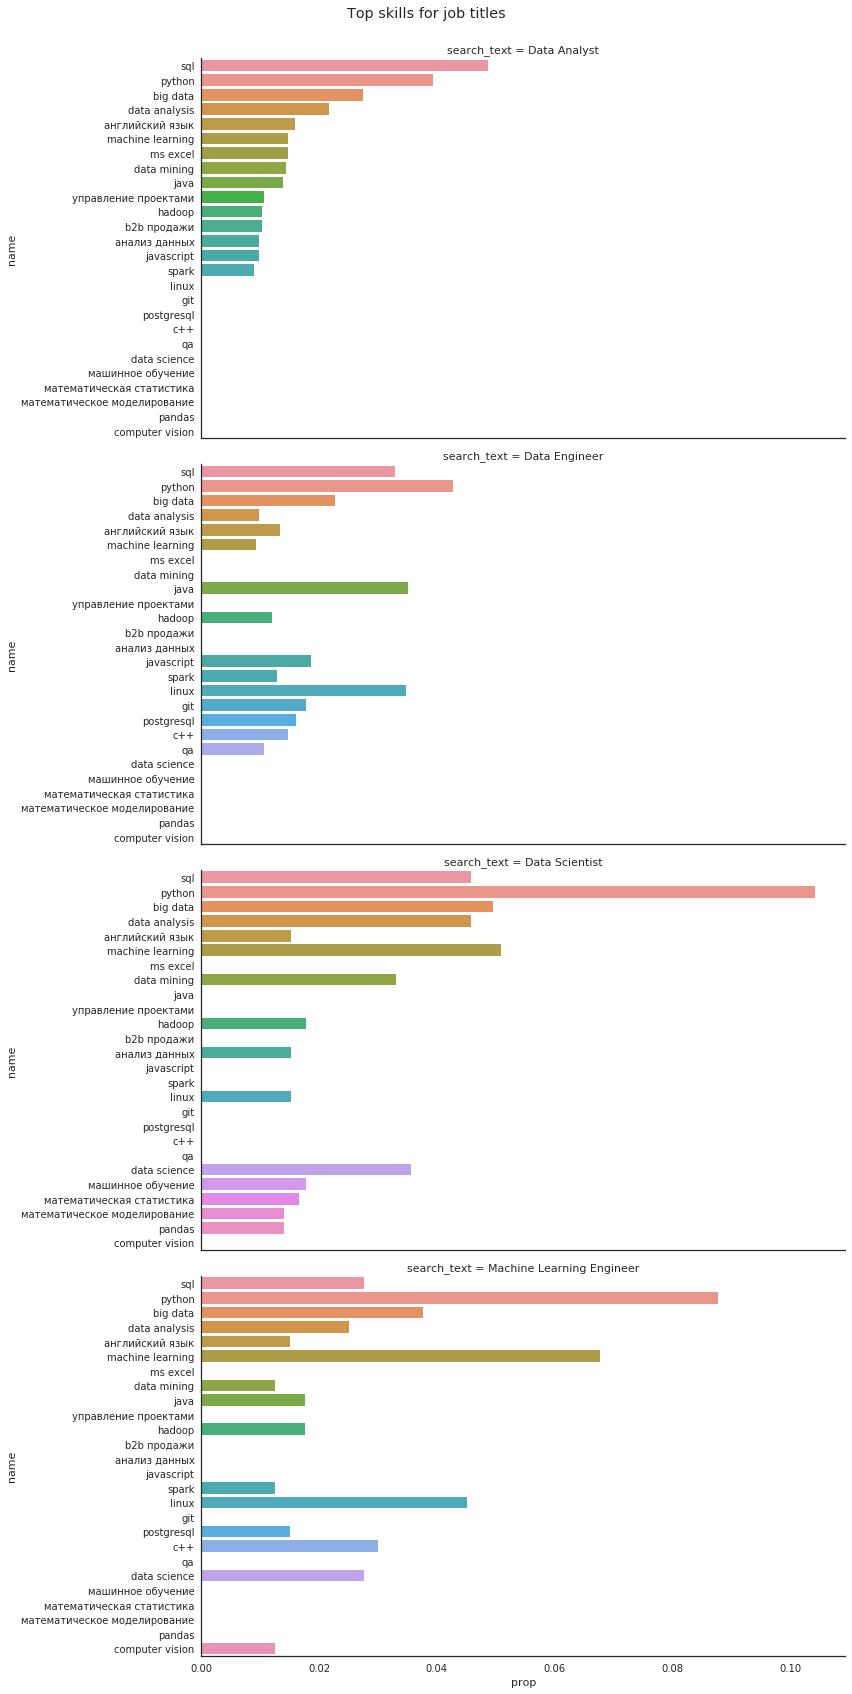

In [10]:
def get_top_n(group, n=10):
    return group.sort_values('count', ascending=False)[:n]

count_df = (key_skills_df.groupby(['search_text', 'name'], as_index=False)
                         .agg([('count', 'count')])['id']
                         .reset_index())
count_df = (count_df.groupby('search_text', as_index=False, group_keys=False)
                    .apply(lambda x: x.assign(prop = x['count'] / x['count'].sum())))
top15_df = count_df.groupby(['search_text'], as_index=False, group_keys=False).apply(get_top_n, n=15)

sns.factorplot(x='prop', y='name', row='search_text', data=top15_df, kind='bar', orient='h', size=6, aspect=2)
plt.subplots_adjust(top=0.95)
plt.gcf().suptitle('Top skills for job titles')

plt.show()

Отобразим top 15 ключевых навыков для каждой из должностей в виде word cloud

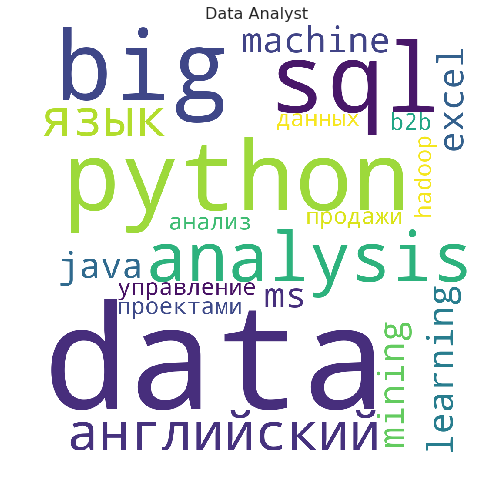

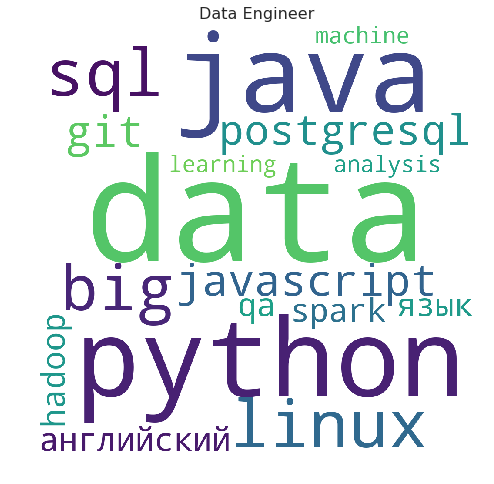

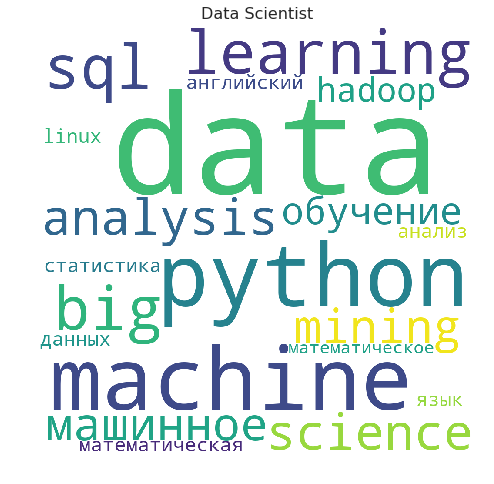

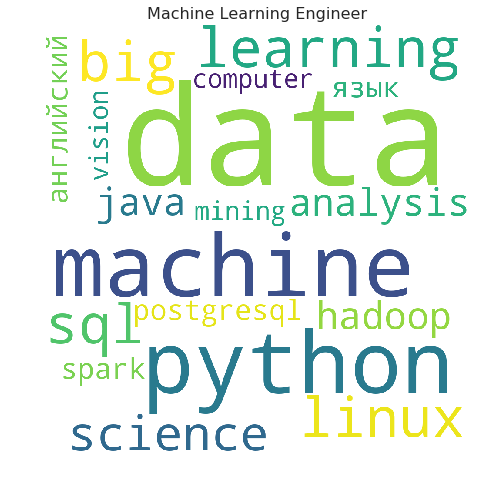

In [11]:
jobs_top15 = dict(list(top15_df.groupby('search_text')))
for search_text, job_df in jobs_top15.items():
    wordcloud = WordCloud(background_color='white', max_words=20, width=1000, height=1000).generate(' '.join(job_df['name']))
    plt.imshow(wordcloud)
    plt.gca().set_title(search_text, fontsize=16)
    plt.axis('off')
    plt.show()

Выберем top 30 ключевых навыков для каждой из должности, и определим уникальные и общие для различных должностей навыки.

In [12]:
top30_df = count_df.groupby(['search_text'], as_index=False, group_keys=False).apply(get_top_n, n=30)
jobs_top30 = dict(list(top30_df.groupby('search_text')))
skills_prop = (top30_df.groupby('name')['count'].sum().sort_values(ascending=False).apply(np.log)
                       .clip_lower(2).to_dict())

data_analyst_skills = set(jobs_top30['Data Analyst']['name'])
data_scientist_skills = set(jobs_top30['Data Scientist']['name'])
data_engineer_skills = set(jobs_top30['Data Engineer']['name'])
machine_learning_skills = set(jobs_top30['Machine Learning Engineer']['name'])

Найдем пересечения в ключевых навыках в 3 должностях, больше связанных с анализом данных, чем с инфраструктурой

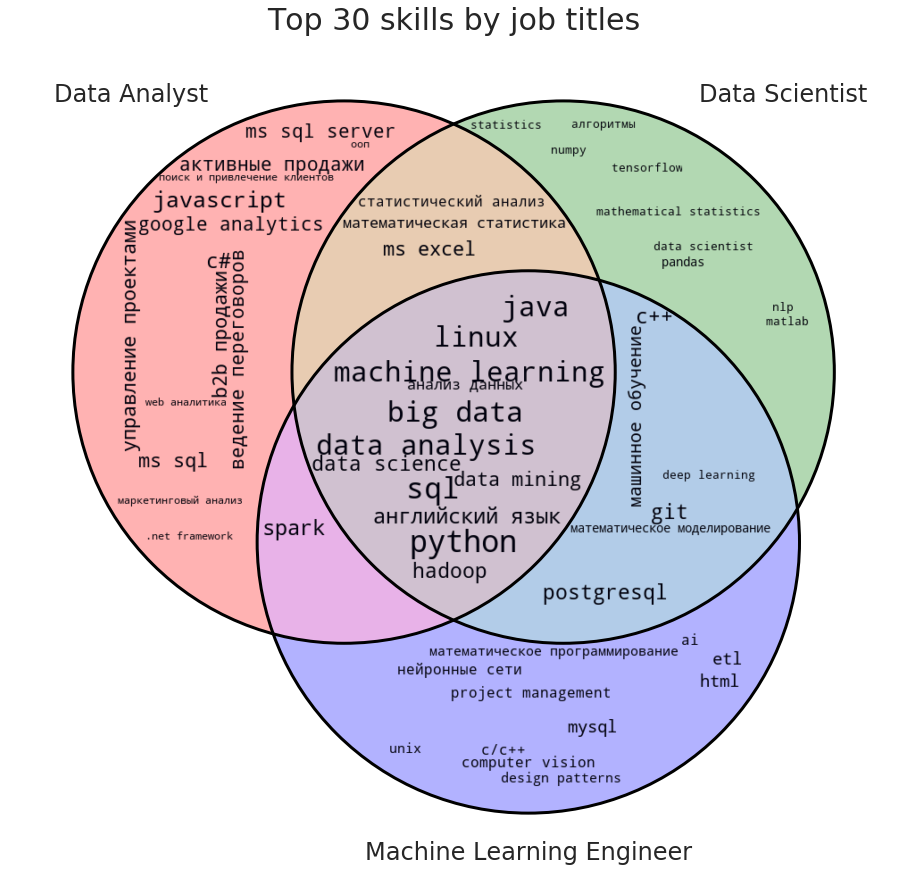

In [13]:
skills_list = [data_analyst_skills, data_scientist_skills, machine_learning_skills]
fig, ax = plt.subplots(1, 1, figsize=(16, 16))
ax.set_title("Top 30 skills by job titles", fontsize=30)
venn3_wordcloud(skills_list, set_labels = ['Data Analyst', 'Data Scientist', 'Machine Learning Engineer'],
                set_colors = ['r', 'g', 'b'], alpha=0.3, word_to_frequency=skills_prop, ax=ax)
plt.show()

Посмотрим подробнее отличия между навыками для должностей Data Analyst и Data Scientist

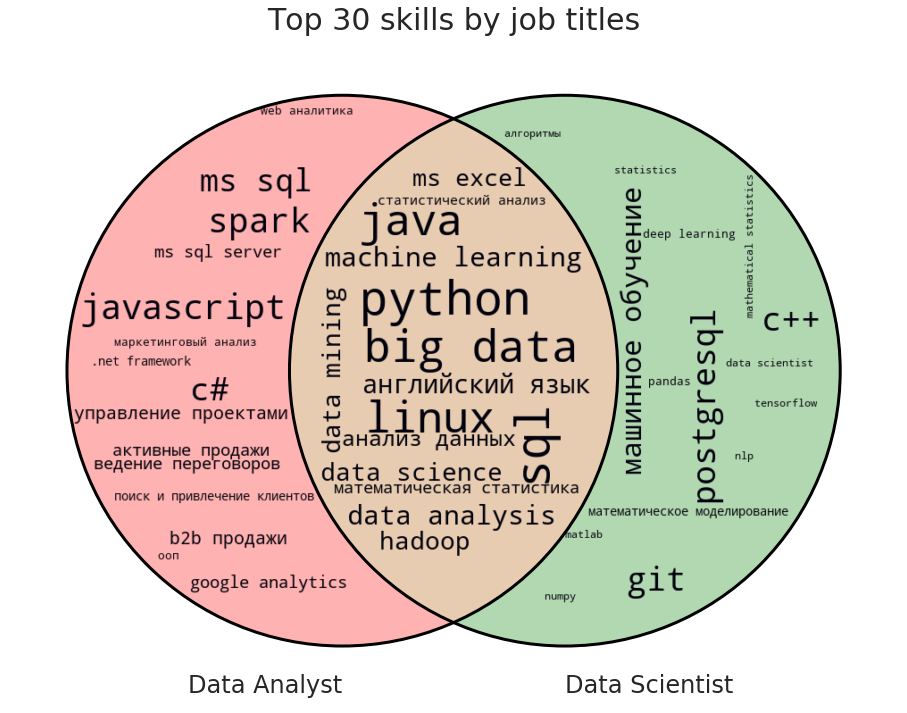

In [14]:
skills_list = [data_analyst_skills, data_scientist_skills]
fig, ax = plt.subplots(1, 1, figsize=(16, 16))
ax.set_title("Top 30 skills by job titles", fontsize=30)
venn2_wordcloud(skills_list, set_labels = ['Data Analyst', 'Data Scientist'],
                set_colors = ['r', 'g'], alpha=0.3, word_to_frequency=skills_prop, ax=ax)
plt.show()

Определим общие навыки, которые необходимы для должностей, где присутствует слово Engineer

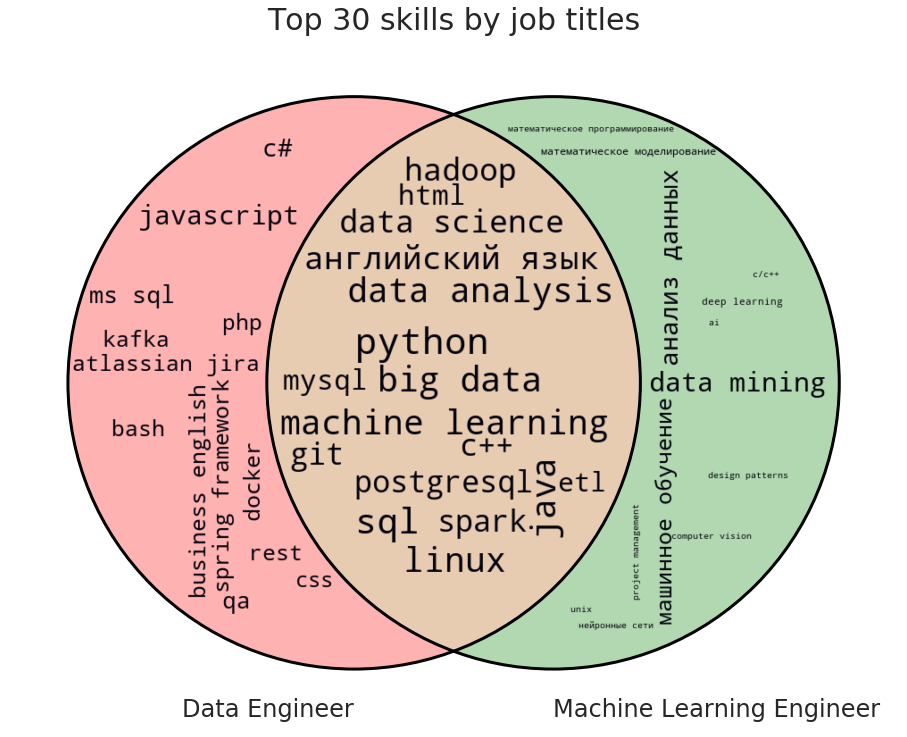

In [15]:
skills_list = [data_engineer_skills, machine_learning_skills]
fig, ax = plt.subplots(1, 1, figsize=(16, 16))
ax.set_title("Top 30 skills by job titles", fontsize=30)
venn2_wordcloud(skills_list, set_labels = ['Data Engineer', 'Machine Learning Engineer'],
                set_colors = ['r', 'g'], alpha=0.3, word_to_frequency=skills_prop, ax=ax)
plt.show()

**Выводы**  
- Data Analyst - помимо общих навыков, включает в себя навыки работы с клиентами, их привлечения, презентации результатов  
- Data Scientist - включает в себя глубокие знания в различных областях математики, а также многие навыки для должностей Data Analyst и Machine Learning Engineer  
- Machine Learning Engineer - более глубокие навыки в программировании, чем в 2 должностях выше, в этой области большое пересечение с Data Engineer  
- Data Engineer - глубокие навыки в хранилищах данных и в инфраструктуре, системном администрировании и виртуализации

### Какое распределение найденных уникальных вакансий в Москве?

In [16]:
# Оставим только вакансии с координатами (широта/долгота)
geo_df = detail_df.dropna(subset=['address.lat', 'address.lng'])

# Отобразим распределение вакансий
median_lat = geo_df['address.lat'].median()
median_lng = geo_df['address.lng'].median()
mapper = folium.Map(location=(median_lat, median_lng), zoom_start=10)
vacancies = geo_df[['address.lat', 'address.lng']].as_matrix().tolist()
mapper.add_child(plugins.HeatMap(vacancies, radius=20))
mapper

**Выводы**
- В центре Москвы распределение вакансий достаточно равномерное  
- В восточных округах Москвы намного меньше вакансий, чем в западных

### Какое распределение зарплат (не учитывая, чистая или белая ЗП, в связи с различными налоговыми ставками в разных странах) относительно должностей, по которым производился поиск?

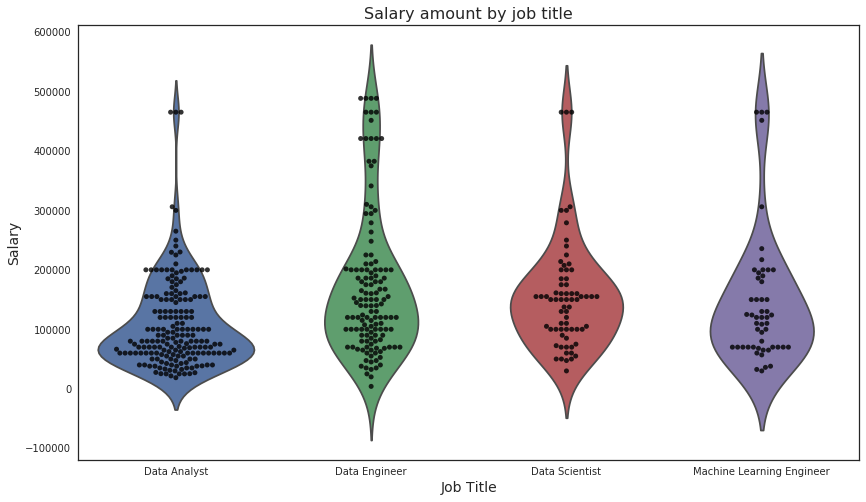

In [17]:
def calc_salary(rec):
    if pd.isnull(rec['salary.from.rur']):
        rec['salary'] = rec['salary.to.rur']
    elif pd.isnull(rec['salary.to.rur']):
        rec['salary'] = rec['salary.from.rur']
    else:
        rec['salary'] = rec[['salary.from.rur', 'salary.to.rur']].mean()
    return rec

# Объединим информацию по вакансиям с должностями, с данными курсов валют относительно российского рубля
salary_df = pd.merge(all_vacancies_df, quotes_df, how='left', left_on='salary.currency', right_index=True)

# Рассчитываем минимальные и максимальные ЗП без учета, до вычета налогов или после, по курсу указанной валютсы
salary_df['salary.from.rur'] = (salary_df['salary.from'] * salary_df['currency.rate'])
salary_df['salary.to.rur'] = (salary_df['salary.to'] * salary_df['currency.rate'])

# Удаляем все должности, где нет ни одного из значений (from/to) по ЗП
salary_df = salary_df.dropna(how='all', subset=['salary.from.rur', 'salary.to.rur'])

# Рассчитываем единое значение ЗП по каждой из вакансий
salary_df = salary_df.apply(calc_salary, axis=1)

# Отображаем данные по распределению ЗП
sns.violinplot(x='search_text', y='salary', data=salary_df, inner=None)
ax = sns.swarmplot(x='search_text', y='salary', data=salary_df, color='k', alpha=0.8)

ax.set_title('Salary amount by job title', fontsize=16)
ax.set_xlabel('Job Title', fontsize=14)
ax.set_ylabel('Salary', fontsize=14)

plt.show()

**Выводы**  
- Типичная ЗП для вакансий Data Analyst имеет меньшее значение, чем остальные должности
- Data Engineers имеют более высокооплачиваемые предложения
- ЗП для вакансий для Data Scientist и Machine Learning не имеют видимых особенных различий